# Import Modules

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf

from datetime import datetime
from keras.layers import Dense
from keras.models import Sequential
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import chi2
from sklearn.feature_selection import r_regression, SelectKBest
from sklearn.feature_selection import r_regression, SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils._testing import ignore_warnings
from tensorflow import keras
from keras.callbacks import TensorBoard
from tabulate import tabulate
from xgboost import XGBClassifier

%matplotlib inline


In [34]:
pd.set_option('display.show_dimensions', True)
pd.set_option('display.max_columns', 200)


# Load Data

In [35]:
df = pd.read_csv('../Datasets/titanic.csv')

In [36]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Length: 12, dtype: int64

In [38]:
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Cabin'].fillna('Unknown', inplace=True)
df['Embarked'].fillna('Unknown', inplace=True)

# Categorical Encoding

In [39]:
# create a dataframe copy just for feature selection
df_fs = df.copy(deep=True)

# encode the categorical data
cat_cols = [col for col in df_fs.columns if df_fs[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df_fs[cat_cols] = oe.fit_transform(df_fs[cat_cols])

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [40]:
df.shape

(891, 12)

There is no categorical features in this dataset. We will proceed forward using the original dataframe (df).

# Feature Selection

## Drop Useless Features

In [41]:
x = df_fs.drop('Survived', axis=1)
y = df_fs['Survived']

In [42]:
# create this empty set to collect only the selected features later
features = set()

## Lasso Model

In [43]:
reg = LassoCV()
reg.fit(x, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(x, y))
coef = pd.Series(reg.coef_, index=x.columns)

Best alpha using built-in LassoCV: 0.016064
Best score using built-in LassoCV: 0.389652


In [44]:
print("Lasso picked " + str(sum(coef != 0)) +
      " variables and eliminated the other " + str(sum(coef == 0)) + " variables.")

Lasso picked 10 variables and eliminated the other 1 variables.


Text(0.5, 1.0, 'Feature importance using Lasso Model')

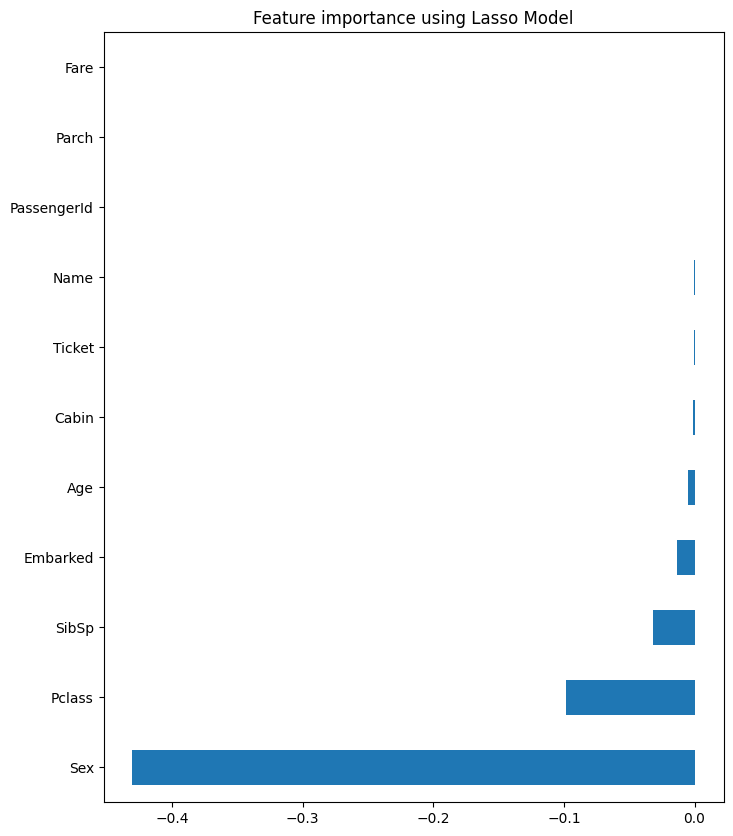

In [45]:
imp_coef = coef.sort_values()
mpl.rcParams['figure.figsize'] = (8, 10)
imp_coef.plot(kind="barh")
plt.title("Feature importance using Lasso Model")


In [46]:
for item in imp_coef[imp_coef != 0].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding Sex.
Adding Pclass.
Adding SibSp.
Adding Embarked.
Adding Age.
Adding Cabin.
Adding Ticket.
Adding Name.
Adding PassengerId.
Adding Fare.


## Chi-square

In [47]:
# x contains negative values that cannot be used for chi2
# let's normalize x
scalar = MinMaxScaler()
x_chi = scalar.fit_transform(x)
chi_scores = chi2(x_chi, y)

<AxesSubplot:>

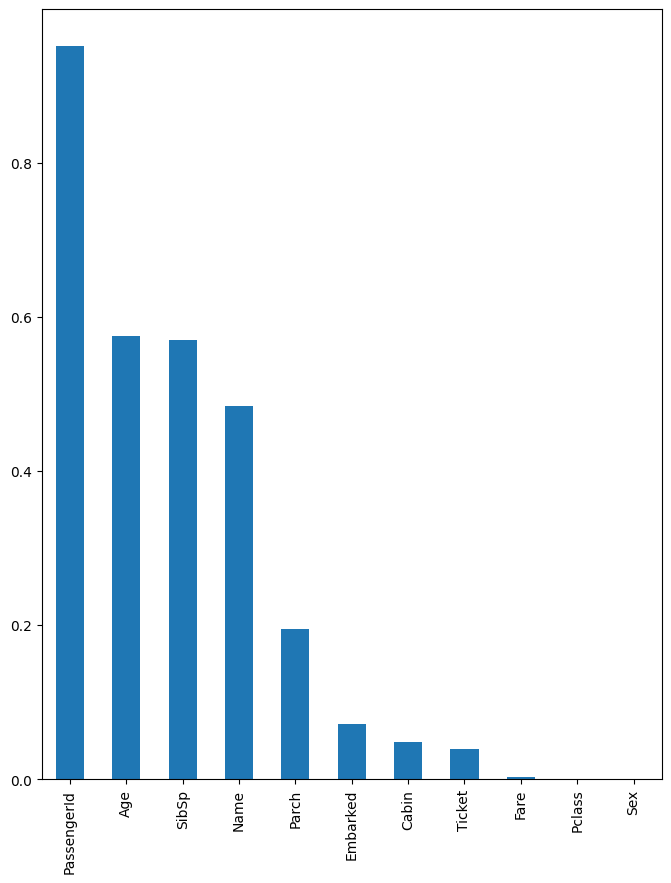

In [48]:
# extract and plot the p-values
p_values = pd.Series(chi_scores[1], index=x.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()

In [49]:
for item in p_values[p_values > 0.001].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding PassengerId.
Adding Age.
Adding SibSp.
Adding Name.
Adding Parch.
Adding Embarked.
Adding Cabin.
Adding Ticket.
Adding Fare.


## ANOVA f-value

<AxesSubplot:>

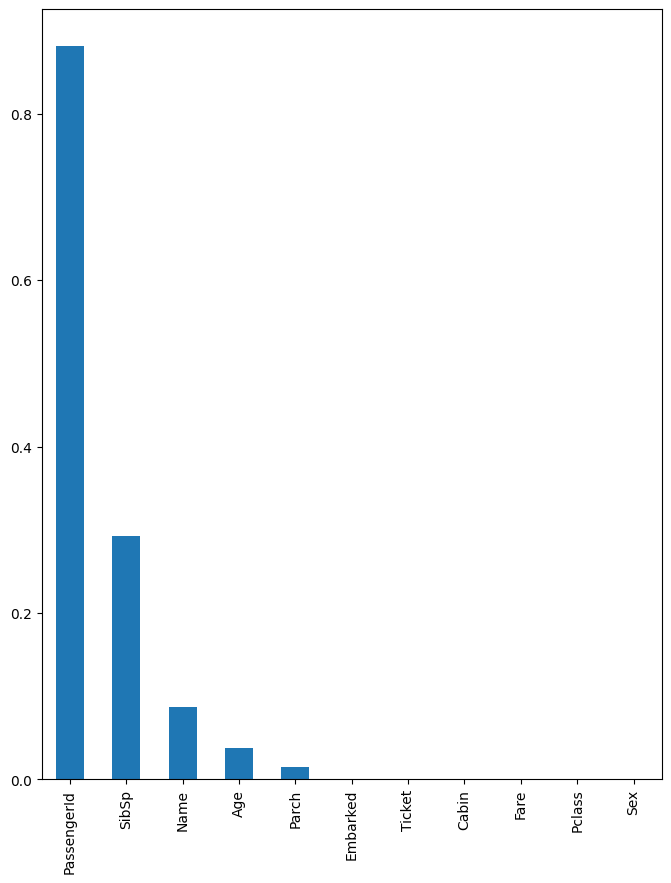

In [50]:
f_scores = f_regression(x, y)
# extract and plot the p-values
p_values = pd.Series(f_scores[1], index=x.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()

In [51]:
for item in p_values[p_values > 0.0001].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding PassengerId.
Adding SibSp.
Adding Name.
Adding Age.
Adding Parch.


## Selected Features

In [52]:
print(f'These are the selected features: {features}.')

These are the selected features: {'Sex', 'Cabin', 'PassengerId', 'Age', 'Embarked', 'Name', 'Ticket', 'Parch', 'Pclass', 'Fare', 'SibSp'}.


In [53]:
# categorical encoded columns + selected features only
x = df_fs[list(features)]
y = df_fs['Survived']

# Machine Learning

In [54]:
# sc = StandardScaler()
# x = sc.fit_transform(x)

In [55]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

In [56]:
@ignore_warnings(category=ConvergenceWarning)
class ClassifierModels():
    def __init__(self, df, x, y, x_test, y_test):
        '''Init function. Make sure to pass x_train and y_train here.'''

        self.df = df
        self.x = x
        self.y = y
        self.x_test = x_test
        self.y_test = y_test
        
        print('#' * 60)
        print(f'{" Loading dataframe ":#^60}')
        print('#' * 60)
        print(f'{" Getting best parameters to create our models ":#^60}')
        print('#' * 60)

        # hold abbreviations and full names
        self.model_abr = {
            'lr': 'Logistic Regression',
            'knn': 'KNeighbors Classifier',
            'svm': 'Support Vector Machine',
            'dtc': 'Decision Tree Classifier',
            'rfc': 'Random Forest Classifier',
            'ensemble': 'Voting Classifier',
            'xgb': 'XGB Classifier',
            'nb': 'Naive Bayes'
            }

        # hold the actual models
        self.models = {}
        self.model_predicts = {}
        self.model_predicts_proba = {}

        # loop over the models dict to get each model's best params
        for model in self.model_abr:
            print('#' * 60)
            print(f'{" " + self.model_abr[model] + " ":#^60}')
            print('#' * 60)
            params = self.get_best_params(model)

            print('+++++ Best parameters for the {} model: {}'.format(
                self.model_abr[model], params))
            print('+++++ Creating and fitting the {} model using its best parameters...'.format(
                self.model_abr[model]))
            # print('+++++ Creating and fitting the {} model using its default parameters...'.format(
            #     self.model_abr[model]))

            if model == 'lr':
                m = LogisticRegression(
                    solver=params['solver'],
                    penalty=params['penalty'],
                    C=params['C'],
                    n_jobs=-1
                    )
                # m = LogisticRegression(n_jobs=-1)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'knn':
                m = KNeighborsClassifier(
                    n_neighbors=params['n_neighbors'],
                    weights=params['weights'],
                    metric=params['metric'],
                    n_jobs=-1
                    )
                # m = KNeighborsClassifier(n_jobs=-1)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'svm':
                m = SVC(
                    kernel=params['kernel'],
                    C=params['C'],
                    gamma=params['gamma'],
                    probability=True
                    )
                # m = SVC(probability=True)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'dtc':
                m = DecisionTreeClassifier(
                    criterion=params['criterion'],
                    splitter=params['splitter'],
                    max_features=params['max_features']
                    )
                # m = DecisionTreeClassifier()
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'rfc':
                m = RandomForestClassifier(
                    n_estimators=params['n_estimators'],
                    max_features=params['max_features'],
                    n_jobs=-1
                    )
                # m = RandomForestClassifier(n_jobs=-1)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'ensemble':
                m = VotingClassifier(
                    estimators=[
                        ('Logistic Regression', self.models['lr']),
                        ('Decission Tree Classifier', self.models['dtc']),
                        ('Random Forrest Classifier', self.models['rfc']),
                        ('KNN', self.models['knn']),
                        ('SVM', self.models['svm'])
                        ],
                    weights=[10, 10, 10, 10, 10],
                    # weights=[10, 10, 10, 10],
                    voting='soft', 
                    n_jobs=-1)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'xgb':
                m = XGBClassifier(use_label_encoder=False)
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'nb':
                m = GaussianNB()
                m.fit(self.x, self.y)

                self.models[model] = m

        print('#' * 60)
        print(f'{" All models created and fitted successfully! ":#^60}')
        print('#' * 60)

        # loop over the models and get the y_pred
        for model in self.model_abr:
            y_pred = self.models[model].predict(self.x_test)

            self.model_predicts[model] = y_pred
        
        print('#' * 60)
        print(f'{" All y_preds created successfully! ":#^60}')
        print('#' * 60)

        # loop over the models and get the y_pred_proba
        for model in self.model_abr:
            y_pred_proba = self.models[model].predict_proba(self.x_test)

            self.model_predicts_proba[model] = y_pred_proba
        
        print('#' * 60)
        print(f'{" All y_pred_probas created successfully! ":#^60}')
        print('#' * 60)

    @ignore_warnings(category=ConvergenceWarning)
    def get_best_params(self, model):
        '''This method returns the best params for hypertuning each model'''

        if model == 'lr':
            # model
            lr_model = LogisticRegression()

            # params
            solver = ['newton-cg', 'lbfgs', 'liblinear']
            penalty = ['l2']
            C = [100, 10, 1.0, 0.1, 0.01]
            lr_params = dict(solver=solver, penalty=penalty, C=C)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=1, random_state=1)
            lr_gsearch = GridSearchCV(
                estimator=lr_model,
                param_grid=lr_params,
                cv=cv,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            lr_gresult = lr_gsearch.fit(self.x, self.y)

            return lr_gresult.best_params_

        elif model == 'knn':
            # model
            knn_model = KNeighborsClassifier()

            # params
            n_neighbors = [50, 100, 500]
            weights = ['uniform', 'distance']
            metric = ['euclidean', 'manhattan', 'minkowski']
            knn_params = dict(n_neighbors=n_neighbors,
                              weights=weights, metric=metric)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=1, random_state=1)
            knn_gsearch = GridSearchCV(
                estimator=knn_model,
                param_grid=knn_params,
                cv=cv,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            knn_gresult = knn_gsearch.fit(self.x, self.y)

            return knn_gresult.best_params_

        elif model == 'svm':
            # model
            svm_model = SVC()

            # params
            kernel = ['poly', 'rbf', 'sigmoid']
            C = [50, 10, 1.0, 0.1, 0.01]
            gamma = ['scale']
            svm_params = dict(kernel=kernel, C=C, gamma=gamma)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=1, random_state=1)
            svm_gsearch = GridSearchCV(
                estimator=svm_model,
                param_grid=svm_params,
                cv=None,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            svm_gresult = svm_gsearch.fit(self.x, self.y)

            return svm_gresult.best_params_

        elif model == 'dtc':
            # model
            dtc_model = DecisionTreeClassifier()

            # params
            criterion = ['gini', 'entropy']
            splitter = ['best', 'random']
            max_features = ['sqrt', 'log2', None]
            dtc_params = dict(criterion=criterion,
                              splitter=splitter, max_features=max_features)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=1, random_state=1)
            dtc_gsearch = GridSearchCV(
                estimator=dtc_model,
                param_grid=dtc_params,
                cv=None,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            dtc_gresult = dtc_gsearch.fit(self.x, self.y)

            return dtc_gresult.best_params_

        elif model == 'rfc':
            # model
            rfc_model = RandomForestClassifier()

            # params
            n_estimators = [10, 100, 1000]
            max_features = ['sqrt', 'log2']
            rfc_params = dict(n_estimators=n_estimators,
                              max_features=max_features)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=2, n_repeats=1, random_state=1)
            rfc_gsearch = GridSearchCV(
                estimator=rfc_model,
                param_grid=rfc_params,
                cv=None,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            rfc_gresult = rfc_gsearch.fit(self.x, self.y)

            return rfc_gresult.best_params_

        elif model == 'ensemble':
            return

        elif model == 'xgb':
            return

        elif model == 'nb':
            return

        else:
            raise NameError(
                'No grid search model available for {}.'.format(model))

    def show_performance(self):
        '''This method prints the accuracy, precision, recall, and f1 score for each model.'''

        headers = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        tbldata = []
        for model in self.models:
            accuracy = metrics.accuracy_score(
                self.y_test, self.model_predicts[model])
            f1score = metrics.f1_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)
            precision = metrics.precision_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)
            recall = metrics.recall_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)

            tbldata.append([self.model_abr[model], accuracy,
                           precision, recall, f1score])

        return tabulate(tbldata, headers=headers, tablefmt="pretty")

In [57]:
cm = ClassifierModels(df_fs[list(features)], x_train, y_train, x_test, y_test)

############################################################
#################### Loading dataframe #####################
############################################################
####### Getting best parameters to create our models #######
############################################################
############################################################
################### Logistic Regression ####################
############################################################
+++++ Best parameters for the Logistic Regression model: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
+++++ Creating and fitting the Logistic Regression model using its best parameters...


/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

############################################################
################## KNeighbors Classifier ###################
############################################################
+++++ Best parameters for the KNeighbors Classifier model: {'metric': 'euclidean', 'n_neighbors': 50, 'weights': 'distance'}
+++++ Creating and fitting the KNeighbors Classifier model using its best parameters...
############################################################
################## Support Vector Machine ##################
############################################################


/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/neighbors

+++++ Best parameters for the Support Vector Machine model: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
+++++ Creating and fitting the Support Vector Machine model using its best parameters...
############################################################
################# Decision Tree Classifier #################
############################################################
+++++ Best parameters for the Decision Tree Classifier model: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}
+++++ Creating and fitting the Decision Tree Classifier model using its best parameters...
############################################################
################# Random Forest Classifier #################
############################################################
+++++ Best parameters for the Random Forest Classifier model: {'max_features': 'sqrt', 'n_estimators': 1000}
+++++ Creating and fitting the Random Forest Classifier model using its best parameters...
#################

/Users/sergani/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


############################################################
############ All y_preds created successfully! #############
############################################################
############################################################
######### All y_pred_probas created successfully! ##########
############################################################


## Model Performance

In [58]:
print('Performance of the different models:\n', cm.show_performance(), sep='')

Performance of the different models:
+--------------------------+--------------------+--------------------+--------------------+--------------------+
|                          |      Accuracy      |     Precision      |       Recall       |      F1 Score      |
+--------------------------+--------------------+--------------------+--------------------+--------------------+
|   Logistic Regression    | 0.8044692737430168 | 0.8050345226502267 | 0.8044692737430168 | 0.804726204495958  |
|  KNeighbors Classifier   | 0.6759776536312849 | 0.6763478201575156 | 0.6759776536312849 | 0.6382755186003205 |
|  Support Vector Machine  | 0.7318435754189944 | 0.7479360645561763 | 0.7318435754189944 | 0.7059577909443744 |
| Decision Tree Classifier | 0.8100558659217877 | 0.8086234063887696 | 0.8100558659217877 | 0.808916808614549  |
| Random Forest Classifier | 0.8547486033519553 | 0.8545933771174798 | 0.8547486033519553 | 0.8528275997255709 |
|    Voting Classifier     | 0.8435754189944135 | 0.8468667

### ROC

Text(0.5, 1.0, 'ROC Curves for Models')

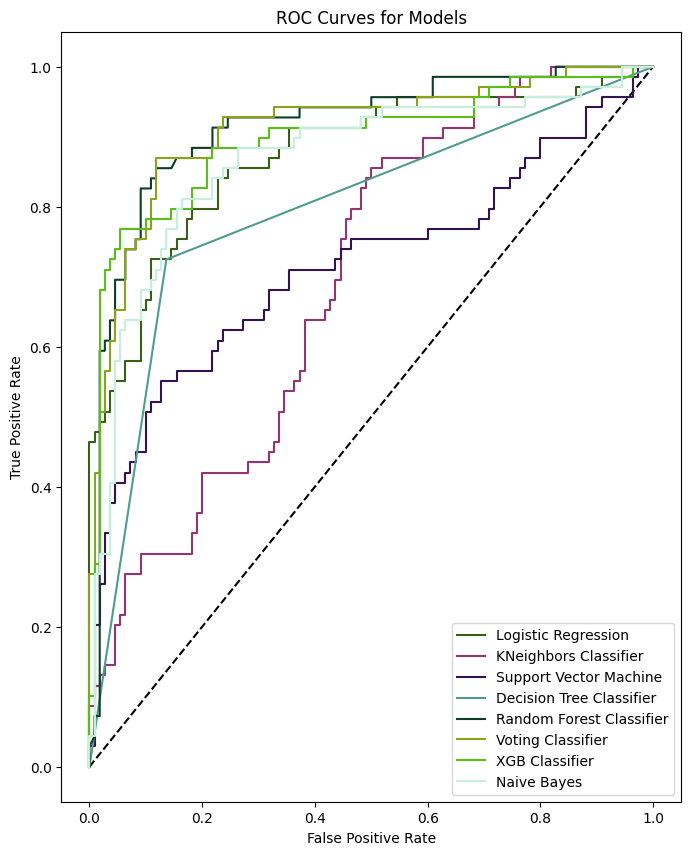

In [59]:
# collect the ROC results
roc_results = {}

for model in cm.model_abr:
    fpr, tpr, thresholds = roc_curve(
        cm.y_test, cm.model_predicts_proba[model][:, 1])

    roc_results[model] = [fpr, tpr, thresholds]

# graph the ROC of all of the models
fig, ax0 = plt.subplots()

ax0.plot([0, 1], [0, 1], 'k--')
for model in roc_results:
    ax0.plot(roc_results[model][0],
             roc_results[model][1], c=np.random.rand(3,), label=cm.model_abr[model])
ax0.set_xlabel('False Positive Rate')
ax0.set_ylabel('True Positive Rate')

ax0.legend()
ax0.set_title('ROC Curves for Models')

### AUC

In [60]:
# table headers and a dictionary to hold the values
headers = ['AUC']
tbl_data_dict = {}

# loop over the classifier models and then their keys abbreviated keys
for k in cm.model_abr:
    auc = roc_auc_score(cm.y_test, cm.model_predicts_proba[k][:, 1])
    tbl_data_dict.setdefault(cm.model_abr[k], []).append(auc)

# create the table data from the dictionary created above
# tabulate doesn't take table data in the form of dictionary created above
tbldata = []
for k, v in tbl_data_dict.items():
    tbldata.append([k] + v)

print(tabulate(tbldata, headers=headers, tablefmt='pretty'))


+--------------------------+--------------------+
|                          |        AUC         |
+--------------------------+--------------------+
|   Logistic Regression    | 0.8744400527009224 |
|  KNeighbors Classifier   | 0.6936758893280632 |
|  Support Vector Machine  | 0.7159420289855073 |
| Decision Tree Classifier | 0.7941370223978921 |
| Random Forest Classifier | 0.9152832674571806 |
|    Voting Classifier     | 0.9122529644268775 |
|      XGB Classifier      | 0.8956521739130435 |
|       Naive Bayes        | 0.8669301712779973 |
+--------------------------+--------------------+


# Deep Learning

In [61]:
%load_ext tensorboard

# create folders
now = datetime.now().strftime('%Y%m%d%H%M')
# log_folder = f'/tmp/keras_logs_{today}'
log_folder = f'Tensorboard Logs/Classification - Titanic Survivors {now}'

# callbacks for TensorBoard
callbacks = TensorBoard(log_dir=log_folder, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [62]:
# create a new dataframe copy and encode its categorical columns
df_dl = df.copy(deep=True)

cat_cols = [col for col in df_dl.columns if df_dl[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df_dl[cat_cols] = oe.fit_transform(df_dl[cat_cols])

# x and y
x_dl = df_dl.drop('Survived', axis=1).values
y_dl = df_dl['Survived'].values

# # categorical encoded columns + selected features only
# x = df[list(features)]
# y = df['Class']


['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [63]:
# clear previous sessions
keras.backend.clear_session()

# create keras model
model = keras.models.Sequential([
    keras.layers.Dense(10, activation='relu', input_dim=x_dl.shape[1]),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # in case of multiple classification use more perceptrons and softmax
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                120       
                                                                 
 dense_1 (Dense)             (None, 8)                 88        
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


In [64]:
# sc = StandardScaler()
# x_scaled = sc.fit_transform(x_dl)

model.compile(optimizer='Adam', loss='BinaryCrossentropy',
              metrics=['AUC', 'Precision', 'Recall'])

model.fit(x=x_dl, y=y_dl, validation_split=0.2,
          epochs=50, callbacks=callbacks)

Epoch 1/50
23/23 [==============================] - 1s 20ms/step - loss: 16.8674 - auc: 0.4908 - precision: 0.2667 - recall: 0.0288 - val_loss: 2.7063 - val_auc: 0.5065 - val_precision: 0.2439 - val_recall: 0.1562
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 3.6164 - auc: 0.4901 - precision: 0.3621 - recall: 0.3777 - val_loss: 4.0915 - val_auc: 0.5383 - val_precision: 1.0000 - val_recall: 0.0312
Epoch 3/50
23/23 [==============================] - 0s 5ms/step - loss: 2.6256 - auc: 0.4922 - precision: 0.3582 - recall: 0.2590 - val_loss: 2.2265 - val_auc: 0.6069 - val_precision: 0.6667 - val_recall: 0.0938
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 1.9570 - auc: 0.5143 - precision: 0.3868 - recall: 0.2950 - val_loss: 2.1427 - val_auc: 0.6540 - val_precision: 1.0000 - val_recall: 0.1094
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 1.5180 - auc: 0.5439 - precision: 0.4238 - recall: 0.3201 - val_loss: 1.4209 -